In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-t38j8syz
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-t38j8syz
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 73.8 MB/s 
     |████████████████████████████████| 7.6 MB 61.2 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175239 sha256=a18412584625f8cedd5c94ac712232f1a4cdc34fbe10a389f8293e8de5bcad80
  Stored in directory: /tmp/pip-ephem-wheel-cache-fp5mbjkv/wheels/16/15/89/1c7bb31bd0006793a95549d04785121a8a36daad9158e1e43a
Successfully built whisper
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import whisper
import json
import os
import tensorflow as tf
from tqdm.notebook import tqdm
import torch
import torchaudio
import torchaudio.transforms as T
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from time import perf_counter
import pandas as pd
import numpy as np
import IPython
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
torch.use_deterministic_algorithms = True

In [ ]:
# path to audio samples
directory = "/content/drive/MyDrive/Whisper_testing/RetailValidated/"
files = os.listdir(directory)
json_files = [directory + file for file in files if file.endswith(".json")]
json_files.sort()

In [ ]:
en_files = []
hi_files = []
gold_labels = []
for i in range(len(json_files)):
    with open(json_files[i],"r") as f:
        data = json.load(f)
        lang = data['speech']['language']
        if lang == "en-IN":
            en_files.append(json_files[i])
            gold_labels.append(1)
        elif lang == "hi-IN":
            hi_files.append(json_files[i])
            gold_labels.append(0)
len(en_files), len(hi_files)

(276, 61)

In [ ]:
index = 0
IPython.display.Audio(hi_files[index].replace(".json", ".wav"))

In [ ]:
#Testing with CLSRIL - 23
model = AutoModel.from_pretrained('Harveenchadha/wav2vec2-pretrained-clsril-23-10k')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(file_path):
    with torch.no_grad():
        clip, sample_rate = torchaudio.load(file_path)
        x = model(clip.to(device))
    return torch.mean(x.extract_features, dim = 1)[0].cpu().numpy()

In [ ]:
# Creating speech representation for audio samples
en_embeddings = []
hi_embeddings = []
for file in tqdm(en_files):
    file_name = file.replace(".json", ".wav")
    en_embeddings.append(get_embeddings(file_name))
    
for file in tqdm(hi_files):
    file_name = file.replace(".json", ".wav")
    hi_embeddings.append(get_embeddings(file_name))

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
en_embeddings = np.array(en_embeddings)
hi_embeddings = np.array(hi_embeddings)
all_embeddings = np.concatenate((en_embeddings, hi_embeddings), 0)
all_embeddings.shape, en_embeddings.shape, hi_embeddings.shape

((337, 512), (276, 512), (61, 512))

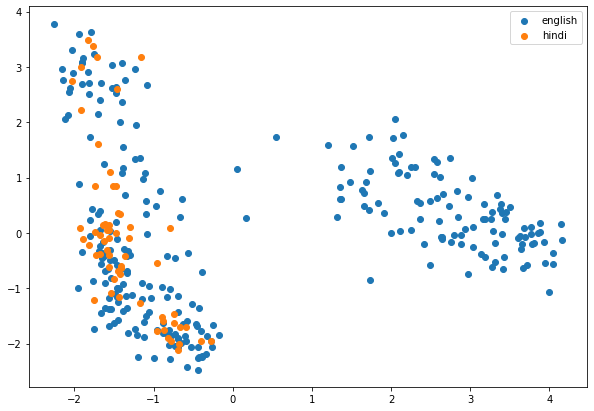

In [ ]:
pca = PCA(n_components=2)
all_pca_embedded = pca.fit_transform(all_embeddings)
hi_pca_embeddings = pca.transform(hi_embeddings)
en_pca_embeddings = pca.transform(en_embeddings)
plt.figure(figsize=(10,7))
plt.scatter(en_pca_embeddings[:, 0], en_pca_embeddings[:, 1])
plt.scatter(hi_pca_embeddings[:, 0], hi_pca_embeddings[:, 1])
plt.legend(["english","hindi"])

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit(all_embeddings)

KMeans(n_clusters=2, random_state=10)

In [ ]:
gold_labels = [1] * len(en_embeddings) + [0] * len(hi_embeddings)
kmeans.labels_

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def predict(clip):
  with torch.no_grad():
   x = model(clip.cuda())
   x = torch.mean(x.extract_features, dim = 1)[0].cpu().numpy()
   return kmeans.predict(x.reshape(1,-1))

In [ ]:
times = [] 
labels = []
for file in tqdm(en_files):
    file_name = file.replace(".json", ".wav")
    clip, sample_rate = torchaudio.load(file_name)
    clip = clip.cuda()
    start = perf_counter()
    p = predict(clip)
    times.append(perf_counter() - start)
    
for file in tqdm(hi_files):
    file_name = file.replace(".json", ".wav")
    clip, sample_rate = torchaudio.load(file_name)
    clip = clip.cuda()
    start = perf_counter()
    p = predict(clip)
    times.append(perf_counter() - start)

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
metrics = []
accuracy = accuracy_score(kmeans.labels_, gold_labels)
precision = precision_score(kmeans.labels_, gold_labels)
recall = recall_score(kmeans.labels_, gold_labels)
f1 = f1_score(kmeans.labels_, gold_labels)
metrics.append(["CLSRIL-23", np.percentile(times, 99), accuracy, precision, recall, f1])

In [ ]:
#Testing with Whisper variants
label_dict = {"en":1, "hi": 0}
model_names = ['tiny', 'base', 'small', 'medium']
for model_name in model_names:
  model = whisper.load_model(model_name)
  device = torch.device("cuda:0")
  model = model.to(device)
  predictions = []
  times = []
  for file in tqdm(en_files):
    file_name = file.replace(".json", ".wav")
    audio = whisper.load_audio(file_name)
    start = perf_counter()
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    _, probs = model.detect_language(mel)
    new_probs = dict((k, probs[k]) for k in ('en', 'hi'))
    pred =  max(new_probs, key=new_probs.get)
    times.append(perf_counter() - start)
    predictions.append(label_dict[pred])
    
  for file in tqdm(hi_files):
    file_name = file.replace(".json", ".wav")
    audio = whisper.load_audio(file_name)
    start = perf_counter()
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(model.device)
    _, probs = model.detect_language(mel)
    new_probs = dict((k, probs[k]) for k in ('en', 'hi'))
    pred =  max(new_probs, key=new_probs.get)
    times.append(perf_counter() - start)
    predictions.append(label_dict[pred])

  accuracy = accuracy_score(predictions, gold_labels)
  precision = precision_score(predictions, gold_labels)
  recall = recall_score(predictions, gold_labels)
  f1 = f1_score(predictions, gold_labels)
  metrics.append([model_name, np.percentile(times, 99), accuracy, precision, recall, f1])

100%|█████████████████████████████████████| 72.1M/72.1M [00:03<00:00, 21.7MiB/s]


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 52.7MiB/s]


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 461M/461M [00:09<00:00, 51.1MiB/s]


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

100%|█████████████████████████████████████| 1.42G/1.42G [00:26<00:00, 58.7MiB/s]


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
metric_df = pd.DataFrame(metrics)
metric_df.columns = ["model", "latency", "accuracy", "precision", "recall", "f1-score"]
metric_df  

,model,latency,accuracy,precision,recall,f1-score
0,CLSRIL-23,0.089796,0.492582,0.380435,1.000000,0.551181
1,tiny,0.049856,0.821958,0.869565,0.909091,0.888889
2,base,0.111418,0.821958,0.844203,0.932000,0.885932
3,small,0.169418,0.816024,0.807971,0.961207,0.877953
4,medium,0.495411,0.908012,0.920290,0.965779,0.942486
